### Import Package

In [1]:
import ray
import json
import time
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community as community_louvain 
import logging
import warnings

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from collections import Counter
from openai import OpenAI
from adjustText import adjust_text
from wordcloud import WordCloud
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt, before_sleep_log
from networkx.drawing.nx_agraph import graphviz_layout

from class_data.data import Data
from class_generate.gen_emb import GenEmb
from utils.system import *

#### Get GPT Topic

In [ ]:
# Load openai embeddings
wsj_openai = Data(folder_path=get_format_data() / 'openai', file_pattern='wsj_emb_openai_*')
wsj_openai = wsj_openai.concat_files()

# Load articles
wsj_art = Data(folder_path=get_format_data() / 'token', file_pattern='wsj_tokens_*')
wsj_art = wsj_art.concat_files()

# Params
type = 'embedding'
vector_column = 'ada_embedding'
interval = 'M'
threshold = 0.77

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("-" * 120)
query = 'Generate an index with label Artificial Intelligence from January 1st, 1984, to December 31st, 2021.'
generate = GenEmb(query=query, vector_data=wsj_openai, vector_column=vector_column, article_data=wsj_art, interval=interval, threshold=threshold)
index = generate.generate_emb()
topic = GptTopic(query='Artificial Intelligence', index=index, score_col='score', article_col='body_txt', topic_col='topic', top_n=100, batch_size=16, output="ai_index")
topic.get_topic()

### Fetch Data

In [24]:
output = 'ai_index'

In [27]:
gpt_topic = pd.read_csv(f'../../plot/{output}/topic.csv')
gpt_topic = gpt_topic.loc[gpt_topic['topic'] != '[None]']

In [28]:
gpt_topic.head(5)

,score,headline,body_txt,topic
0,5.750132e-06,Japan to Raise Spending On Computer Project A ...,Japan plans to raise government spending in th...,"['Government Funding', 'Brain-like Computing',..."
7,2.434326e-07,IBM System Attempts Supervision of Computers,YORKTOWN HEIGHTS N.Y. International Business ...,"['Expert Systems', 'Decision-making', 'Lisp Pr..."
9,5.276593e-06,Texas Instruments Inc. Offers Computer for Use...,DALLAS Texas Instruments Inc. announced a com...,"['Hardware for AI', 'AI Applications', 'Progra..."
19,8.857904e-06,Xerox Corp. Unit Unveils 2 Computer Workstations,LOS ANGELES Xerox Corp.s Xerox Artificial Int...,"['Computer Workstations', 'LISP Programming', ..."
20,4.104329e-05,Business Brief: Applied Expert Systems Inc.,APPLIED EXPERT SYSTEMS INC. a closely held Cam...,"['Expert Systems', 'Financial AI Applications'..."


In [29]:
# Convert string representations to actual lists
gpt_topic['topic'] = gpt_topic['topic'].apply(lambda x: ast.literal_eval(x))

### Plot

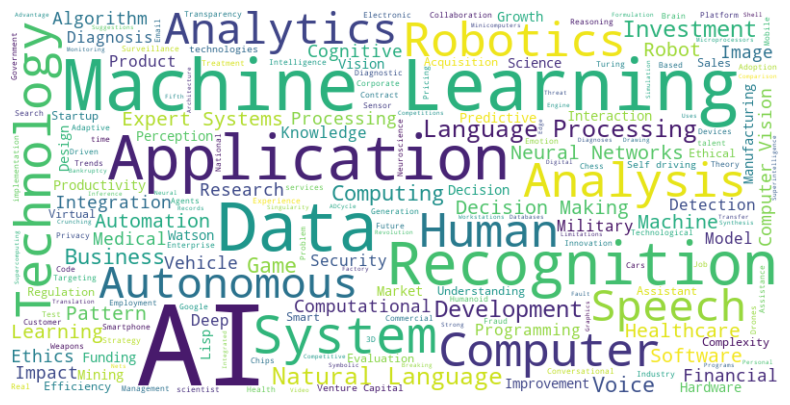

In [30]:
# Joining topics correctly
all_topics = ' '.join([' '.join(topics) for topics in gpt_topic['topic'] if topics])
# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_topics)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

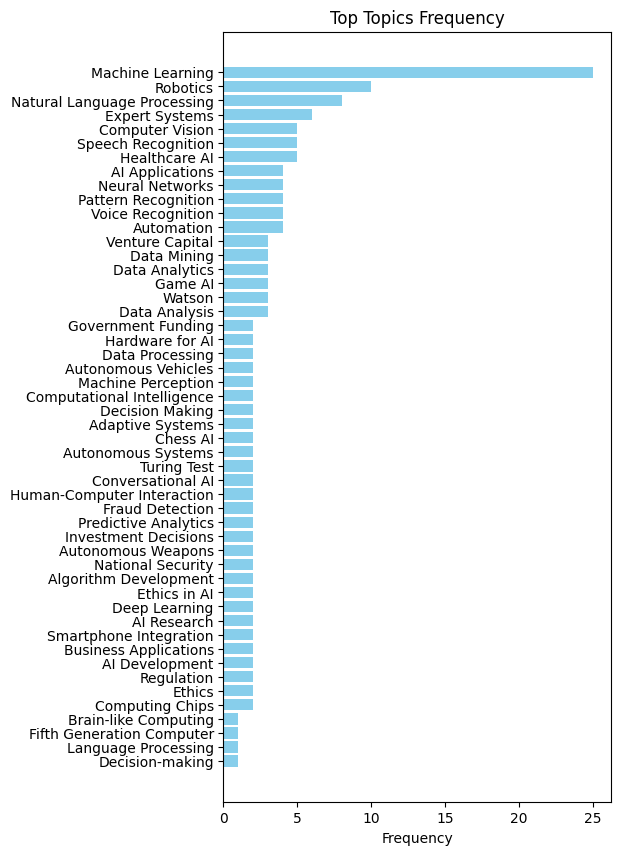

In [36]:
# Flatten the list of lists to count the frequency of each topic
all_topics_flat = [topic for topics in gpt_topic['topic'] for topic in topics]
topic_counts = Counter(all_topics_flat)
topics, frequencies = zip(*topic_counts.most_common(50))
plt.figure(figsize=(5, 10))
plt.barh(topics, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top Topics Frequency')
plt.gca().invert_yaxis()

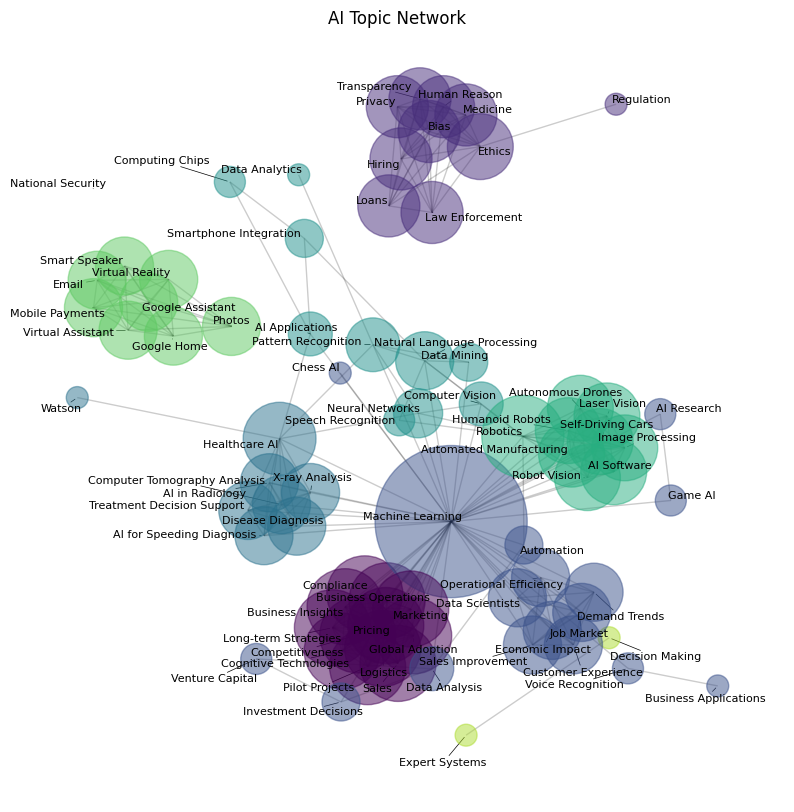

In [21]:
# Create the network graph 'G'
G = nx.Graph()

for topics in gpt_topic['topic']:
    # Add edges between all topics that co-occur in the same list
    for i in range(len(topics)):
        for j in range(i+1, len(topics)):
            G.add_edge(topics[i], topics[j])

# Keep nodes with a degree greater than 1 (adjust as needed)
nodes_to_keep = [node for node, degree in G.degree() if degree > 6]
H = G.subgraph(nodes_to_keep).copy()

# Community detection on the subgraph 'H'
partition_subgraph = community_louvain.best_partition(H)
# Generate colors for the nodes in the subgraph based on the community partition
colors_subgraph = [partition_subgraph.get(node) for node in H.nodes()]

# Node sizes based on degree (or another metric)
degrees_subgraph = dict(H.degree())
node_sizes_subgraph = [degrees_subgraph[node] * 250 for node in H.nodes()]  # Adjust the multiplier as needed

# Layout for 'H'
pos_subgraph = nx.spring_layout(H, k=0.25, iterations=25)  # Increased spacing with k

# Draw the network graph for the subgraph 'H'
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(H, pos_subgraph, node_size=node_sizes_subgraph, node_color=colors_subgraph, cmap=plt.get_cmap('viridis'), alpha=0.5)
nx.draw_networkx_edges(H, pos_subgraph, alpha=0.2)
# nx.draw_networkx_labels(H, pos_subgraph, font_size=8, alpha=1)
texts = [plt.text(x, y, node, fontsize=8, ha='center', va='center') for node, (x, y) in pos_subgraph.items()]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('AI Topic Network')
plt.axis('off')
plt.show()